# Training of a sequential neural network for soil moisture prediction

In [ ]:
# BEGIN IMPORTS #
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import SGD

from sklearn import preprocessing

from matplotlib import pyplot
import datetime

import numpy as np
import scipy
import pandas as pd
# END IMPORTS #

In [ ]:
dataset = "data/soil.txt"
file1 = open(dataset, "r")


In [ ]:
file1.mode

'r'

In [ ]:
file1.close()

In [ ]:
df = pd.read_csv(dataset)
df


,SAR VH backscatter in dB,SAR VV backscatter in dB,incidence angle in degrees,volumetric soil moisture content
0,-111.440881,-36.467285,30.000000,0.0100
1,-87.612931,-23.666936,30.000000,0.0350
2,-81.519782,-20.147727,30.000000,0.0600
3,-78.338168,-18.243952,30.000000,0.0850
4,-76.294484,-16.992628,30.000000,0.1100
...,...,...,...,...
263,-39.997250,0.945260,32.000000,0.8100
264,-16.550358,-7.048486,30.300486,0.0848
265,-19.314853,-13.688190,30.314545,0.1534
266,-16.578978,-13.389807,30.336458,0.1139


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 268 entries, 0 to 267
Data columns (total 4 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   SAR VH backscatter in dB          268 non-null    float64
 1   SAR VV backscatter in dB          268 non-null    float64
 2   incidence angle in degrees        268 non-null    float64
 3   volumetric soil moisture content  268 non-null    float64
dtypes: float64(4)
memory usage: 8.5 KB


In [ ]:
x = df.drop('volumetric soil moisture content', axis=1)
y = df['volumetric soil moisture content'].copy()

Normalization

In [ ]:
preprocessed_X = preprocessing.minmax_scale(x, feature_range=(0, 1))
preprocessed_X

array([[0.00255986, 0.00343881, 0.        ],
       [0.25302696, 0.34440281, 0.        ],
       [0.31707499, 0.4381443 , 0.        ],
       [0.35051847, 0.48885532, 0.        ],
       [0.37200062, 0.52218692, 0.        ],
       [0.38734481, 0.54639416, 0.        ],
       [0.39904709, 0.56509381, 0.        ],
       [0.40838089, 0.58016293, 0.        ],
       [0.41607337, 0.59268851, 0.        ],
       [0.42257423, 0.60335062, 0.        ],
       [0.42817866, 0.61260018, 0.        ],
       [0.43308967, 0.62074996, 0.        ],
       [0.43745216, 0.62802496, 0.        ],
       [0.44137278, 0.63459193, 0.        ],
       [0.44493208, 0.64057758, 0.        ],
       [0.44819218, 0.64608021, 0.        ],
       [0.45120187, 0.6511774 , 0.        ],
       [0.45399992, 0.65593113, 0.        ],
       [0.45661742, 0.66039124, 0.        ],
       [0.45907924, 0.66459774, 0.        ],
       [0.46140493, 0.66858207, 0.        ],
       [0.46360917, 0.67236773, 0.        ],
       [0.

Split input data into training and test data


In [ ]:
iem_samples = df.shape[0]-4
iem_samples

264

With the variable defined in the previous step, you can split the normalised input (X) and output (y) data into training and test samples. You want to use the 264 IEM_B samples for training and the four samples based on Sentinel-1 images as test data.

In [ ]:
test_X_S1 = preprocessed_X[iem_samples:]
preprocessed_X_iem = preprocessed_X[:iem_samples]

test_y_S1 = y[iem_samples:]
y_iem = y[:iem_samples]
test_y_S1

264    0.0848
265    0.1534
266    0.1139
267    0.1060
Name: volumetric soil moisture content, dtype: float64

In a next step, you want to random shuffle the data.



In [ ]:
s = np.arange(iem_samples)
np.random.shuffle(s)
preprocessed_X_shuffled = preprocessed_X_iem[s]
y_shuffled = y_iem[s]

Split training data into training and test data
The next step splits the training data into two subsets:

train_X / train_y --> 70% of the training data
test_X / test_y --> 30% of the training data.
The first 185 entries (70% of 264) are used for training the model and the remaining data are used for testing. You generate training and testing subsets originating from preprocessed_X_shuffled (input) and y_shuffled (output) data.

In [ ]:
n_train_perc = 0.7
n_train = round(preprocessed_X_shuffled.shape[0] * n_train_perc)
n_train

185

In [ ]:
train_X  = preprocessed_X_shuffled[:n_train, :]
train_y  = y_shuffled[:n_train]

test_X = preprocessed_X_shuffled[n_train:, :]
test_y = y_shuffled[n_train:]

n_train, train_X, test_X

(185,
 array([[0.34785618, 0.48660543, 0.18913674],
        [0.75262981, 0.99387101, 0.        ],
        [0.67357233, 0.86348855, 0.        ],
        [0.42549674, 0.6114119 , 0.18913674],
        [0.40838089, 0.58016293, 0.        ],
        [0.47981326, 0.61070282, 0.18913674],
        [0.475826  , 0.69351731, 0.        ],
        [0.71685606, 0.9421657 , 0.        ],
        [0.63436591, 0.80933768, 0.18913674],
        [0.39636602, 0.56341777, 0.18913674],
        [0.70671699, 0.92007906, 0.18913674],
        [0.47546202, 0.69749077, 0.18913674],
        [0.39904709, 0.56509381, 0.        ],
        [0.46094711, 0.67196671, 0.18913674],
        [0.71522975, 0.94533407, 0.18913674],
        [0.74498177, 0.98500989, 0.18913674],
        [0.6340561 , 0.85948845, 0.18913674],
        [0.46140493, 0.66858207, 0.        ],
        [0.74022567, 0.97255338, 0.        ],
        [0.63229077, 0.8563925 , 0.18913674],
        [0.47640389, 0.69916222, 0.18913674],
        [0.53471108, 0.69478

In [ ]:
test_X,test_y

(array([[0.75357025, 0.99550146, 0.        ],
        [0.75069778, 0.99500373, 0.18913674],
        [0.70270345, 0.91008557, 0.        ],
        [0.70994966, 0.93017913, 0.        ],
        [0.64487951, 0.87289868, 0.        ],
        [0.47132804, 0.68569723, 0.        ],
        [0.62432948, 0.78934424, 0.        ],
        [0.60763793, 0.81384405, 0.18913674],
        [0.70831124, 0.92735037, 0.        ],
        [0.75271078, 0.99854229, 0.18913674],
        [0.46867463, 0.68550085, 0.18913674],
        [0.23799831, 0.2515075 , 0.18913674],
        [0.47031518, 0.68839005, 0.18913674],
        [0.66840825, 0.8649543 , 0.18913674],
        [0.45120187, 0.6511774 , 0.        ],
        [0.61620882, 0.8236003 , 0.        ],
        [0.62266686, 0.79071209, 0.18913674],
        [0.68517593, 0.88799926, 0.        ],
        [0.61391134, 0.8245518 , 0.18913674],
        [0.55235251, 0.71921548, 0.        ],
        [0.73272041, 0.96383738, 0.18913674],
        [0.55243071, 0.68327243, 0

 Define and compile a sequential neural network model with Keras

In [ ]:
model = keras.Sequential()

In [ ]:
# Layer 1
model.add(Dense(8, input_dim=3))
model.add(LeakyReLU(alpha=0.1))

# Layer 2
model.add(Dense(3))
model.add(LeakyReLU(alpha=0.1))

# Layer 3
model.add(Dense(1, activation='sigmoid'))

In [ ]:
model.compile(loss='mean_absolute_error',
              optimizer=SGD(lr=0.01, momentum=0.9),
              metrics=['mse'])

In [ ]:
log_dir = "../../../../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=50)

In [ ]:
mc = keras.callbacks.ModelCheckpoint('gdrive/My Drive/soil moisture/best_model.h5', monitor='val_mse', mode='min', verbose=1, save_best_only=True)

In [ ]:
history = model.fit(train_X, train_y,
                    validation_data=(test_X, test_y),
                    epochs=100,
                    batch_size=10,
                    callbacks=[tensorboard_callback, es, mc])
history

Epoch 1/100
 1/19 [>.............................] - ETA: 9s - loss: 0.2814 - mse: 0.1066
Epoch 1: val_mse improved from inf to 0.05624, saving model to gdrive/My Drive/soil moisture/best_model.h5
19/19 [==============================] - 1s 23ms/step - loss: 0.2334 - mse: 0.0785 - val_loss: 0.2024 - val_mse: 0.0562
Epoch 2/100
 1/19 [>.............................] - ETA: 0s - loss: 0.1691 - mse: 0.0438
Epoch 2: val_mse improved from 0.05624 to 0.05320, saving model to gdrive/My Drive/soil moisture/best_model.h5
19/19 [==============================] - 0s 8ms/step - loss: 0.2123 - mse: 0.0610 - val_loss: 0.1973 - val_mse: 0.0532
Epoch 3/100
 1/19 [>.............................] - ETA: 0s - loss: 0.2750 - mse: 0.0920
Epoch 3: val_mse improved from 0.05320 to 0.05182, saving model to gdrive/My Drive/soil moisture/best_model.h5
19/19 [==============================] - 0s 8ms/step - loss: 0.2107 - mse: 0.0593 - val_loss: 0.1948 - val_mse: 0.0518
Epoch 4/100
 1/19 [>.......................

In [ ]:
model = keras.models.load_model('gdrive/My Drive/soil moisture/best_model1.h5')
model

In [ ]:
_, test_mse = model.evaluate(test_X, test_y)

print('Mse: %.4f' % test_mse)


3/3 [==============================] - 0s 5ms/step - loss: 0.1586 - mse: 0.0374
Mse: 0.0374


Another useful evaluation is to plot the loss and validation_loss metrics during training.
loss: mean absolute error during training (blue line)
validation_loss: mean absolute error while validating the training outputs with test data (orange line)


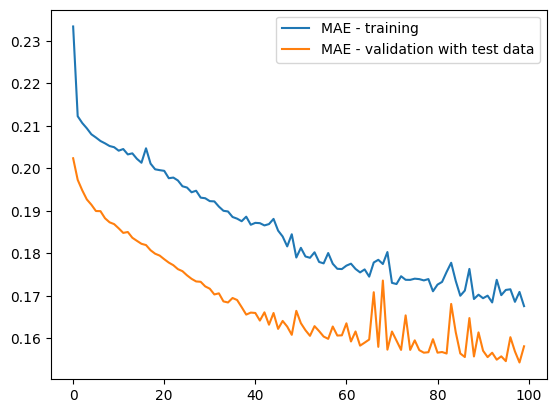

In [ ]:
pyplot.plot(history.history['loss'], label='MAE - training')
pyplot.plot(history.history['val_loss'], label='MAE - validation with test data')
pyplot.legend()

 Predicting soil moisture with the trained sequential neural network


In [ ]:
predicted = []
for index, value in enumerate(test_X_S1):
    pred = np.expand_dims(value, axis=0)
    predicted.append(model.predict(pred))

    print("Input values: " + str(value) + ",  Output soil moisture: ") #+ str(test_y_S1[index]))
    print("Predicted soil moisture: " + str(model.predict(pred)) + "\n ")



1/1 [==============================] - 0s 59ms/step
Input values: [1.         0.78706989 0.02841644],  Output soil moisture: 
1/1 [==============================] - 0s 28ms/step
Predicted soil moisture: [[0.48461]]
 
1/1 [==============================] - 0s 25ms/step
Input values: [0.97094106 0.61020754 0.02974598],  Output soil moisture: 
1/1 [==============================] - 0s 25ms/step
Predicted soil moisture: [[0.3681441]]
 
1/1 [==============================] - 0s 25ms/step
Input values: [0.99969916 0.61815558 0.0318183 ],  Output soil moisture: 
1/1 [==============================] - 0s 23ms/step
Predicted soil moisture: [[0.3776444]]
 
1/1 [==============================] - 0s 21ms/step
Input values: [0.96187422 0.65006854 1.        ],  Output soil moisture: 
1/1 [==============================] - 0s 26ms/step
Predicted soil moisture: [[0.308207]]
 


Text(0, 0.5, 'Predicted')

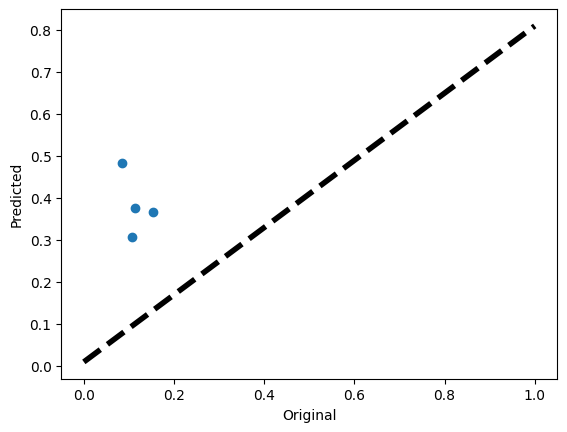

In [ ]:
fig, ax = pyplot.subplots()
ax.scatter(test_y_S1, predicted)
ax.plot([test_y.min(), test_y.max()], 'k--', lw=4)
ax.set_xlabel('Original')
ax.set_ylabel('Predicted')

As a final step, you can calculate the Pearson correlation coefficient between original (to-predict) and predicted soil moisture values. The coefficient value can range between [-1,1] and is a measure about the strength of the correlation between original and predicted soil moisture.

In [ ]:
 test_y_nparray = np.array(test_y_S1)
test_y_flattened = test_y_nparray.flatten()
predicted_nparray = np.array(predicted)
predicted_flattened = predicted_nparray.flatten()

corr, _ = scipy.stats.pearsonr(test_y_flattened, predicted_flattened)
print('Pearson correlation: %.3f' % corr)

Pearson correlation: -0.468
